# **Importing All necessary Modules**

In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import RMSprop
from keras import backend as K
from keras.models import load_model
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Reload the model and freeze the layers**

In [3]:
# VGG was designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 224, 224 

# Re-loads the VGG model without the FC layers
VGG_16 = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in VGG_16.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 6s 0us/step


# **Defining a function for additional layers adding at the top of pre-trained model**

In [0]:
def TopModelVGG_16(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

# **Adding the model and printing the summary**

In [5]:
num_classes = 2

FC_Head = TopModelVGG_16(VGG_16, num_classes)

model = Model(inputs = VGG_16.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

# **Importing dataset and using Image generator for Augmentation**

In [6]:
train_data_dir = '/content/drive/My Drive/FaceRecognition/FaceData/train_data'
validation_data_dir = '/content/drive/My Drive/FaceRecognition/FaceData/val_data'

# Let's use some data augmentation 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 379 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


# **Training the Model**

In [7]:
checkpoint = ModelCheckpoint("/content/drive/My Drive/FaceRecognition/FC_vgg_16.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 379
nb_validation_samples = 48

# We only train 15 EPOCHS 
epochs = 15
batch_size = 16

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/15
23/23 [==============================] - 241s 10s/step - loss: 0.3784 - accuracy: 0.8691 - val_loss: 0.7234 - val_accuracy: 0.7375

Epoch 00001: val_loss improved from inf to 0.72340, saving model to /content/drive/My Drive/FaceRecognition/FC_vgg_16.h5
Epoch 2/15
23/23 [==============================] - 15s 650ms/step - loss: 0.1883 - accuracy: 0.9353 - val_loss: 0.0462 - val_accuracy: 0.9688

Epoch 00002: val_loss improved from 0.72340 to 0.04619, saving model to /content/drive/My Drive/FaceRecognition/FC_vgg_16.h5
Epoch 3/15
23/23 [==============================] - 15s 659ms/step - loss: 0.0904 - accuracy: 0.9738 - val_loss: 0.0711 - val_accuracy: 0.9750

Epoch 00003: val_loss did not improve from 0.04619
Epoch 4/15
23/23 [==============================] - 15s 666ms/step - loss: 0.0361 - accuracy: 0.9890 - val_loss: 2.0280e-04 - val_accuracy: 0.9062

Epoch 00004: val_loss improved from 0.04619 to 0.00020, saving model to /content/drive/My Drive/FaceRecognition/FC_vgg_16.h5

# **Load saved Model**

In [0]:
classifier = load_model('/content/drive/My Drive/FaceRecognition/FC_vgg_16.h5')

# **Lets do a quick prediction over an image**

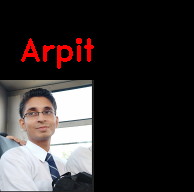

In [14]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

images_dict = {"[0]": "AmitabhJi", 
                      "[1]": "Arpit" }

images_dict_n = { "AmitabhJi": "AmitabhJi" ,
                  "Arpit": "Arpit"  }

img = cv2.imread("/content/ArpitPathak.png")
input_original = img.copy()
input_original = cv2.resize(input_original,None,
                            fx=0.5,fy=0.5,
                            interpolation=cv2.INTER_LINEAR)

img = img / 255
img.resize((224,224,3))
img = img.reshape(1,224,224,3)
res = np.argmax(classifier.predict(img,verbose=0),
                axis = 1)

face = images_dict[str(res)]
BLACK = [0,0,0]
expanded_image = cv2.copyMakeBorder(input_original,
                                    80,0,0,100,
                                    cv2.BORDER_CONSTANT,value=BLACK)
cv2.putText(expanded_image,face,
            (20,60),cv2.FONT_HERSHEY_DUPLEX,
            1,(0,0,255),2)
cv2_imshow(expanded_image)